### Imports

In [1]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev
# dependencies
!pip install --upgrade mani_skill tyro
!pip install sapien

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libvulkan-dev is already the newest version (1.3.204.1-2).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    site.main() # run this so local pip installs are recognized

### Check

In [3]:
# Import required packages
import gymnasium as gym
import mani_skill.envs
import torch
import time
num_envs = 512 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("PickCube-v1", num_envs=num_envs, obs_mode="rgbd")
env.unwrapped.print_sim_details()
obs, _ = env.reset(seed=0)
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

# -------------------------------------------------------------------------- #
Task ID: PickCube-v1, 512 parallel environments, sim_backend=physx_cuda
obs_mode=rgbd, control_mode=pd_joint_delta_pos
render_mode=None, sensor_details=RGBD(128x128)
sim_freq=100, control_freq=20
observation space: Dict('agent': Dict('qpos': Box(-inf, inf, (512, 9), float32), 'qvel': Box(-inf, inf, (512, 9), float32)), 'extra': Dict('is_grasped': Box(False, True, (512,), bool), 'tcp_pose': Box(-inf, inf, (512, 7), float32), 'goal_pos': Box(-inf, inf, (512, 3), float32)), 'sensor_param': Dict('base_camera': Dict('extrinsic_cv': Box(-inf, inf, (512, 3, 4), float32), 'cam2world_gl': Box(-inf, inf, (512, 4, 4), float32), 'intrinsic_cv': Box(-inf, inf, (512, 3, 3), float32))), 'sensor_data': Dict('base_camera': Dict('depth': Box(-32768, 32767, (512, 128, 128, 1), int16), 'rgb': Box(0, 255, (512, 128, 128, 3), uint8))))
(single) action space: Box(-1.0, 1.0, (8,), float32)
# ----------------------------------------

dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data'])
dict_keys(['base_camera'])
dict_keys(['depth', 'rgb'])
torch.Size([512, 128, 128, 3])


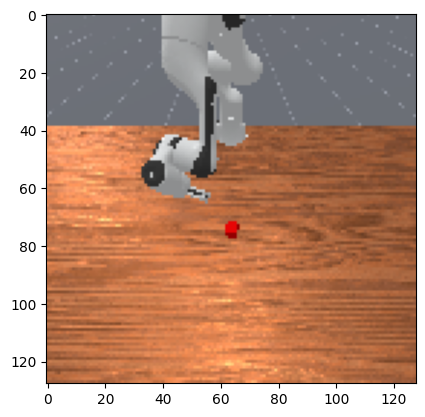

In [4]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt
plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())

### Shit class
Right here you need to change MyEnv to smth other if updating


In [41]:

from mani_skill.envs.tasks.empty_env import EmptyEnv
from mani_skill.envs.sapien_env import BaseEnv

from typing import Dict

from mani_skill.agents.robots.fetch import FETCH_WHEELS_COLLISION_BIT
from mani_skill.utils.building.ground import build_ground
# from mani_skill.utils.scene_builder import SceneBuilder
from mani_skill.utils.registration import register_env
from mani_skill.utils import common, sapien_utils
import sapien
from mani_skill.sensors.camera import CameraConfig

import numpy as np
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm import tqdm
from mani_skill.utils.wrappers import RecordEpisode

ENV_NAME ="MyEmptyEnv5"

@register_env(ENV_NAME, max_episode_steps=200000)
class MyEmptyEnv(BaseEnv):
    SUPPORTED_REWARD_MODES = ["none"]
    """
    This is just a dummy environment for showcasing robots in a empty scene
    """

    def __init__(self, *args, robot_uids="panda", **kwargs):
        super().__init__(*args, robot_uids=robot_uids, **kwargs)

    @property
    def _default_sensor_configs(self):
        pose = sapien_utils.look_at([1.25, -1.25, 1.5], [0.0, 0.0, 0.2])
        return [CameraConfig("base_camera", pose, 128, 128, np.pi / 2, 0.01, 100)]

    @property
    def _default_human_render_camera_configs(self):
        pose = sapien_utils.look_at([1.25, -1.25, 1.5], [0.0, 0.0, 0.2])
        return CameraConfig("render_camera", pose, 2048, 2048, 1, 0.01, 100)

    def _load_agent(self, options: dict):
        super()._load_agent(options, sapien.Pose(p=[-0.615, 0, 0]))

    def _load_scene(self, options: dict):
        self.ground = build_ground(self.scene)
        self.ground.set_collision_group_bit(group=2, bit_idx=30, bit=1)


        #===============================
        # Load URDF articuation
        #===============================
        loader = self.scene.create_urdf_loader()
        articulation_builders = loader.parse(str('./scene.urdf'))["articulation_builders"]
        builder = articulation_builders[0]

        builder.initial_pose = sapien.Pose(p=[0, 0, 0.5])
        builder.build(name="my_articulation")


        #===============================
        # Load actor from glb
        #===============================
        # scale=np.array([1.0, 1.0, 1.0])
        # builder = self.scene.create_actor_builder()
        # builder.add_convex_collision_from_file(
        #     filename="/home/kvsoshin/Work/AIRI/ManiSkill/textures/milk_carton.glb",
        #     scale=scale
        # )
        # builder.add_visual_from_file(filename="/home/kvsoshin/Work/AIRI/ManiSkill/textures/milk_carton.glb", scale=scale)
        # builder.set_initial_pose(sapien.Pose(p=[0.0, 0.0, 0.0]))
        # self.mesh = builder.build_static(name="mesh")



    def _initialize_episode(self, env_idx: torch.Tensor, options: dict):
        if self.robot_uids == "fetch":
            qpos = np.array(
                [
                    0,
                    0,
                    0,
                    0.386,
                    0,
                    0,
                    0,
                    -np.pi / 4,
                    0,
                    np.pi / 4,
                    0,
                    np.pi / 3,
                    0,
                    0.015,
                    0.015,
                ]
            )
            self.agent.reset(qpos)
            self.agent.robot.set_pose(sapien.Pose([10.0, 10, 0.0]))

            self.ground.set_collision_group_bit(
                group=2, bit_idx=FETCH_WHEELS_COLLISION_BIT, bit=1
            )
        else:
            raise NotImplementedError


    def evaluate(self):
        return {}

    def _get_obs_extra(self, info: Dict):
        return dict()


env = gym.make(ENV_NAME, robot_uids='fetch', num_envs=1, render_mode="rgb_array", enable_shadow=True)

pose = sapien_utils.look_at([3.25, -3.25, 1.5], [0.0, 0.0, 0.2])
env._default_human_render_camera_configs = CameraConfig("render_camera", pose, 2048, 2048, 1, 0.01, 100)

env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()


viewer = env.render()
if isinstance(viewer, sapien.utils.Viewer):
    viewer.paused = False
env.render()


for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.zeros_like(torch.from_numpy(action)))

    env.render()
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640)

2025-02-05 12:46:02,952 - mani_skill  - WARNING - Env MyEmptyEnv5 is already registered. Skip registration.
2025-02-05 12:46:03,159 - mani_skill  - WARNING - mani_skill is not installed with git.
100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


### Base env

In [ ]:
from typing import Dict

import numpy as np
import sapien
import torch

from mani_skill.agents.robots.fetch.fetch import Fetch
from mani_skill.agents.robots.panda.panda import Panda
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.sensors.camera import CameraConfig
from mani_skill.utils import sapien_utils
from mani_skill.utils.building.ground import build_ground
from mani_skill.utils.registration import register_env
from mani_skill.utils.structs.types import GPUMemoryConfig, SimConfig


@register_env("Empty-v3", max_episode_steps=200000)
class EmptyEnv(BaseEnv):
    SUPPORTED_REWARD_MODES = ["none"]
    """
    This is just a dummy environment for showcasing robots in a empty scene
    """

    def __init__(self, *args, robot_uids="fetch", **kwargs):
        super().__init__(*args, robot_uids=robot_uids, **kwargs)

    @property
    def _default_sensor_configs(self):
        pose = sapien_utils.look_at([1.25, -1.25, 1.5], [0.0, 0.0, 0.2])
        return [CameraConfig("base_camera", pose, 128, 128, np.pi / 2, 0.01, 100)]

    @property
    def _default_human_render_camera_configs(self):
        pose = sapien_utils.look_at([1.25, -1.25, 1.5], [0.0, 0.0, 0.2])
        return CameraConfig("render_camera", pose, 2048, 2048, 1, 0.01, 100)

    def _load_agent(self, options: dict):
        super()._load_agent(options, sapien.Pose())

    def _load_scene(self, options: dict):
        self.ground = build_ground(self.scene)
        self.ground.set_collision_group_bit(group=2, bit_idx=30, bit=1)

    def _initialize_episode(self, env_idx: torch.Tensor, options: dict):
        pass

    def evaluate(self):
        return {}

    def _get_obs_extra(self, info: Dict):
        return dict()

### Try Video

In [9]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# to make it look a little more realistic, we will enable shadows which make the default lighting cast shadows
env = gym.make("MyEnv1", num_envs=1, render_mode="rgb_array", enable_shadow=True)
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2025-02-05 11:47:40,455 - mani_skill  - WARNING - mani_skill is not installed with git.


  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: Failed to load scene: No suitable reader found for the file format of file "/content/scene.urdf"., /content/scene.urdf